In [0]:
#Import dependencies
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from matplotlib import pyplot as plt
import imghdr

In [0]:
#Set Spark conf to access ADLS
spark.conf.set(f"fs.azure.account.auth.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", f"{dbutils.secrets.get('storageaccount', 'sastoken')}")

In [0]:
#Read image from ADLS as Spark DF
df = spark.read.format("image").load(f"abfss://nga-ml@{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net/clean_room/clean_room_2.jpg")

In [0]:
#Show image metadata
df.select("image.height", "image.width"
         ,"image.nChannels", "image.mode"
         ,"image.data").show()

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|  1000|  667|        3|  16|[7B 7C 8A 7A 7B 8...|
+------+-----+---------+----+--------------------+



In [0]:
#Convert bytearray to numpy ndarray
img_array = np.array(df.select('image.data').collect()[0]['data'])

#Reshape numpy.ndarray to height x width x channels
img_array = img_array.reshape((1000, 667, 3))

#Check shape
img_array.shape

Out[5]: (1000, 667, 3)

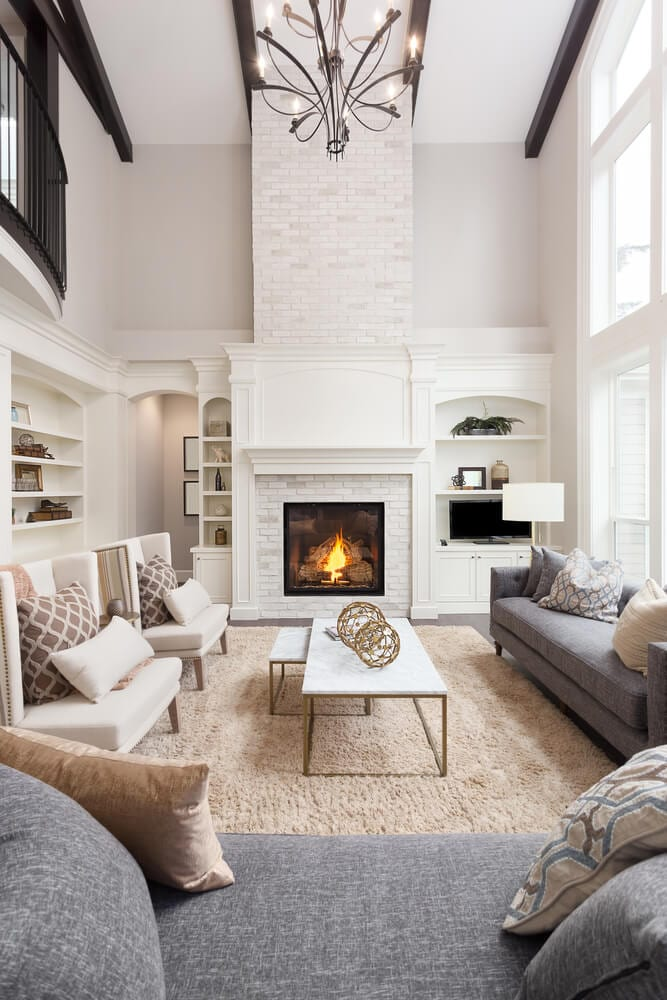

In [0]:
#View image
from dbruntime.patches import cv2_imshow
cv2_imshow(img_array)

In [0]:
#Mount ADLS
config = {"fs.azure.account.key.teststorageaccount1171.blob.core.windows.net":"<Your Key>"}

dbutils.fs.mount(
  source = "wasbs://nga-ml@teststorageaccount1171.blob.core.windows.net",
  mount_point = "/mnt/nga-ml",
  extra_configs = config)

In [0]:
# Clean images by removing any corrupt images
data_dir = "/dbfs/mnt/nga-ml"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [0]:
# Load image datasets using TF
data = tf.keras.utils.image_dataset_from_directory("/dbfs/mnt/nga-ml")

Found 516 files belonging to 2 classes.


In [0]:
# Create iterator
data_iterator = data.as_numpy_iterator()

In [0]:
batch = data_iterator.next()

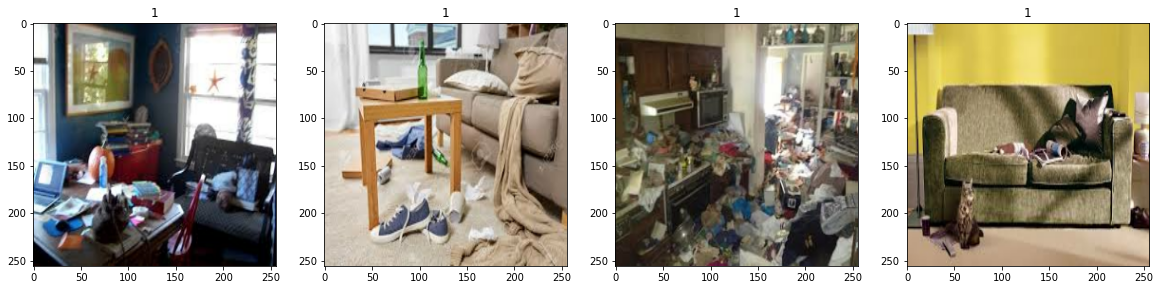

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [0]:
# Scale data
data = data.map(lambda x, y: (x/255, y))

In [0]:
scaled_iterator = data.as_numpy_iterator()

In [0]:
batch = scaled_iterator.next()

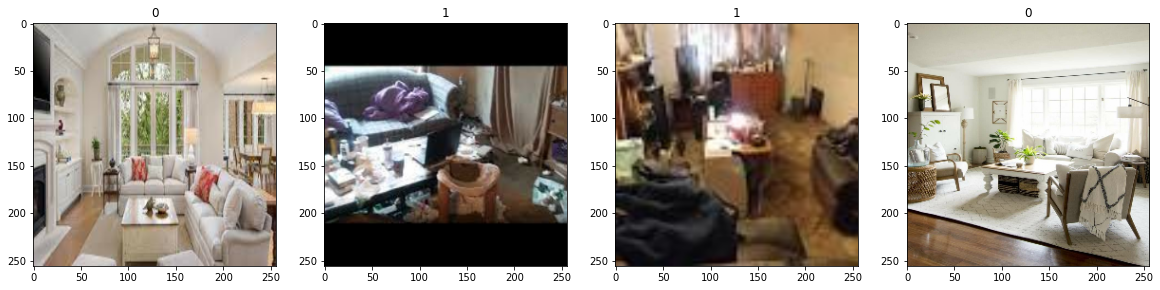

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [0]:
# Split data
train_size = int(len(data) * 0.7) + 1
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

In [0]:
 train_size + val_size + test_size == len(data)

Out[26]: True

In [0]:
# Partition data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [0]:
# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

In [0]:
# # Setup logging
# logdir = "/dbfs/mnt/logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
12/12 [==============================] - 59s 3s/step - loss: 0.8513 - accuracy: 0.6745 - val_loss: 0.5633 - val_accuracy: 0.7266
Epoch 2/20
12/12 [==============================] - 52s 3s/step - loss: 0.5419 - accuracy: 0.6719 - val_loss: 0.4878 - val_accuracy: 0.7031
Epoch 3/20
12/12 [==============================] - 51s 3s/step - loss: 0.4828 - accuracy: 0.6823 - val_loss: 0.3499 - val_accuracy: 0.7891
Epoch 4/20
12/12 [==============================] - 51s 3s/step - loss: 0.4286 - accuracy: 0.8151 - val_loss: 0.4559 - val_accuracy: 0.7656
Epoch 5/20
12/12 [==============================] - 51s 3s/step - loss: 0.4042 - accuracy: 0.8229 - val_loss: 0.3172 - val_accuracy: 0.8828
Epoch 6/20
12/12 [==============================] - 52s 3s/step - loss: 0.3063 - accuracy: 0.8880 - val_loss: 0.2604 - val_accuracy: 0.9062
Epoch 7/20
12/12 [==============================] - 52s 3s/step - loss: 0.2155 - accuracy: 0.9219 - val_loss: 0.1742 - val_accuracy: 0.9453
Epoch 8/20
12/12 [==

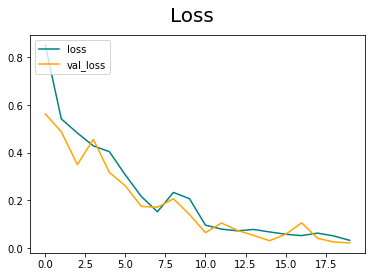

In [0]:
# Plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

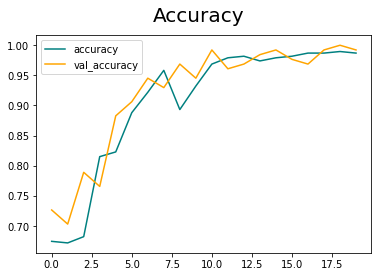

In [0]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()